<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/Bermudan5F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential PCA and regression on the Bermudan five-factor dataset

---
Brian Huge & Antoine Savine, August 2021
---

This notebook applies <b> Differential PCA </b> and <b> Differential regression</b>, introduced in the October 2021 Risk article <b> Axes that matter: PCA with a difference</b>, and implemented in the notebooks [DifferentialPCA.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialPCA.ipynb) and [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb), to the classic problem of of the continuation value and the risk factors of Bermudan swaptions. We refer to the classic papers [Valuing American Options by Simulation: A Simple Least-Squares Approach by Longstaff and Schwartz](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=137399) and [Factor Dependence of Bermudan Swaption Prices: Fact or Fiction? by Andersen and Andreasen](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=209988) for an exposition of the Bermudan problem, well-known in quantitative finance practitioner and academic circles. 

While the problem is well documented and understood, this notebook demonstrates the aptitude of differential PCA to find the correct answers from simulated data alone. Along the way, we will highlight some shortcomings of classic PCA for dimension reduction in finance and better appreciate the application of differential PCA to analyze the risks of Derivatives transactions and trading books, automatically, from simulated data. The methodology applied to a particular Bermudan option in a 5F Gaussian model carries over to arbitrary Derivatives transactions or trading books in the context of arbitrary pricing models. 

Implementation code for differential PCA and regression was copied here in the interest of self-containment, although it is advised to read the notebooks [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb) and [DifferentialPCA.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialPCA.ipynb) (preferably in this order) first. The numerical results and charts published in the Risk article were obtained with this notebook.

# Imports

In [123]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print('Running on CoLab')
else:
    colab = False
    # enable full width for wide figures
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
    print('Not running on CoLab')

if colab:
  %matplotlib inline
else:
  %matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
if colab == True: mpl.rc('animation', html='jshtml')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

# constants
epsilon = 1.0e-08

Not running on CoLab


# Copy of implementation code for classic and differential PCA and regression

In [124]:
# classic polynomial regression
def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

# differential polynomial regression
class DifferentialRegression:
    
    def __init__(self, degree=5, alpha=1.0):
        self.degree = degree
        self.polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
        self.alpha = alpha
    
    def fit(self, x, y, z):     
        self.phi_ = self.polynomial_features.fit_transform(x)
        self.powers_ = self.polynomial_features.powers_
        
        self.dphi_ = self.phi_[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + epsilon)
                
        self.lamj_ = ((y ** 2).mean(axis=0) / (z ** 2).mean(axis=0)).reshape(1,1,-1)
        self.dphiw_ = self.dphi_ * self.lamj_
        
        phiTphi = np.tensordot(self.dphiw_, self.dphi_, axes=([0,2],[0,2]))
        phiTz = np.tensordot(self.dphiw_, z, axes=([0,2],[0,1])).reshape(-1,1)
        
        # note we use np.linalg.pinv (as opposed to np.linalg.inv) to perform safe (SVD) inversion, resilient to near singularities
        inv = np.linalg.pinv(self.phi_.T @ self.phi_ + self.alpha * phiTphi, hermitian=True)
        self.beta_ = (inv @ (self.phi_.T @ y + self.alpha * phiTz)).reshape(-1, 1)
        
    def predict(self, x, predict_derivs=False):
        phi = self.polynomial_features.transform(x)
        y_pred = phi @ self.beta_
        
        if predict_derivs:
            dphi = phi[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)
            z_pred = np.tensordot(dphi, self.beta_, (1, 0)).reshape(dphi.shape[0], -1)
            return y_pred, z_pred
        else:
            return y_pred
        
# classic PCA 
from sklearn.decomposition import PCA

# differential PCA
class DiffPCA:
    
    def __init__(self, n_components=None, central=False):
        """
        The API is consistent with sklearn.decomposition.PCA 
        (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
        
        n_components = number of components to keep. If n_components is None all components are kept:
        n_components == n_features
        
        If 0 < n_components < 1, select the number of components such that 
        the amount of 'variance' (squared magnitude) that needs to be explained is greater than the percentage specified by n_components
        
        Default = squared error magnitude (epsilon*total_variance in the article) of 10^(-8), i.e. error norm is 0.01% of total norm
                        
        central = specific to differential PCA, standard scikit-learn PCA is always central. By contrast, 
        differential PCA is noncentral by default, see article
        """
        
        self.n_components = n_components
        self.central = central
        
    def fit(self, X, Z, y=None): # note y is ignored, just like in scikit-learn PCA
        """
        X: input data
        Z: differential data = dy/dZ, see article
        (y: labels)
        """
        
        # data shape
        self.n_samples_, self.n_features_ = X.shape
        
        # central?
        self.mean_ = Z.mean(axis=0) # average differentials
            
        # compute covariance matrix of differentials
        z = Z - self.mean_ if self.central else Z
        self.cov_ = z.T @ z / self.n_samples_
        
        # eigenvalue decomposition
        d, P = np.linalg.eigh(self.cov_)
                
        # reverse order so largest eigenvalues come first
        d = d[::-1]
        P = P[:, ::-1]
        
        sumd = np.cumsum(d)
        total_variance = sumd[-1]

        # find the number of principal components
        if self.n_components is not None: 
            # n_components is larger than 1 = number of components
            if self.n_components >= 1:
                self.n_components_ = self.n_components
            # n_components is smaller than 1 = square magnitude explained
            else:
                sumd /= total_variance
                self.n_components_ = np.searchsorted(sumd, self.n_components) + 1
            
        else:
            self.n_components_ = min(self.n_samples_, self.n_features_)
            
        explained = sumd[self.n_components_-1]
        unexplained = total_variance - explained

        # filter irrelevant components
        d = d[:self.n_components_]
        P = P[:, :self.n_components_]
            
        # results, attributes as in sklearn.decomposition.PCA
        self.components_ = P.T
        self.explained_variance_ = d
        self.explained_variance_ratio_ = d / total_variance
        self.singular_values_ = np.sqrt(d)
        self.noise_variance_ = unexplained
        
    def transform(self, X, Z=None): 
        
        # transformed dataset
        L = X @ self.components_.T
        
        if Z is None:
            return L
        
        else:
            # transformed derivatives
            S = Z @ self.components_.T
            return L, S
        
    def fit_transform(self, X, Z, y=None):
        self.fit(X, Z, y)
        return self.transform(X, Z)
    
    def inverse_transform(self, L, S=None):
        
        # L to X
        X = L @ self.components_
        
        if S is None:
            return X
        
        else:
            # S to Z
            Z = S @ self.components_
            return X, Z

# The Bermudan 5F dataset

The dataset was produced by Monte-Carlo simulation in a five-factor Gaussian Cheyette model (a.k.a. 5F Hull & White, also called 5F Linear Gauss Markov model or simply LGM) calibrated to August 2021 EUR market data in a professional Derivatives system written in C++ and intrumented with [algorithmic adjoint differentiation (AAD)](https://sites.google.com/view/antoinesavine-aad), hence the availability of differential labels.

Multi-factor Cheyette (MFC) models, of which Gaussian models are the simplest variants, are heavily documented in literature, e.g. in [Andersen and Piterbarg's classic textbooks](http://andersen-piterbarg-book.com/), Andreasen's 2005 Risk paper [Back to the Future](https://www.risk.net/derivatives/interest-rate-derivatives/1500253/back-future), or [our presentation](https://medium.com/@antoine_savine/introduction-to-interest-rate-models-22f9abe5e2b8). 

The financial instrument is an idealized fifteen-year EUR payer swap, twice early callable, Bermudan style, in two and five years. 

Let us first load the dataset.

In [125]:
# read dataset

x_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_x_train.csv", header=None).to_numpy() 
y_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_y_train.csv", header=None).to_numpy() 
z_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_z_train.csv", header=None).to_numpy() 

x_test = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_x_test.csv", header=None).to_numpy() 
y_test = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_y_test.csv", header=None).to_numpy() 

print(x_train.shape, y_train.shape, z_train.shape, x_test.shape, y_test.shape)

(32768, 5) (32768, 1) (32768, 5) (128, 5) (128, 1)


We see that the training set consists of 32,768 independent examples in dimension 5. Each training example has inputs $X \in \mathbb{R}^5$ and label $y \in \mathbb{R}$. Differential labels $Z=\partial y / \partial X \in \mathbb{R}^5$ are also available. 

Let us first make sense of this dataset. Pick three random training examples. 

In [126]:
m, n = x_train.shape
num_examples = 3
indices = np.random.choice(m, size=num_examples, replace=False)
x, y, z = x_train[indices], y_train[indices], z_train[indices]
for i in range(num_examples):  print('example', i, ':', x[i], y[i], z[i])

example 0 : [-0.00361351 -0.02505905  0.05305462  0.00501783 -0.02549037] [-1.64622873] [303.0416581  261.7829237  213.1187407  156.7832001   95.63003778]
example 1 : [ 0.01501484  0.06191463 -0.2573829   0.28932201 -0.1092918 ] [8.51338062] [1330.110123    773.3907659   416.4963154   207.9101233    94.64359983]
example 2 : [ 0.01252618 -0.05229839  0.15080934 -0.19794222  0.08954679] [24.85197782] [1135.134238   662.2954764  356.2849784  175.8304108   78.341378 ]


What do these numbers mean exactly?

The inputs $X=\left(X_1, X_2, X_3, X_4, X_5\right)$ encode the state of the yield curve in two years, on the first early exercise date. In the 5F Gaussian model, the yield curve in two years, expressed in terms of instantaneous forward rates (IFR), is given by:

$$
    f\left(T\right) = f\left(0, T\right) + g\left(T\right) + \sum_{i=1}^5 X_i e^{-\kappa_i T}
$$

where $f\left(0, T\right)$ is the initial yield curve today, $g\left(T\right)$ is a deterministic convexity adjustment so the model prevents convexity arbitrage (it has a closed-form expression in the Gaussian case, not important for our purpose) and the vector $\kappa$ of the exponential slopes of random deformations was set to $\left(0, 0.1, 0.25, 0.5, 1\right)$ for the purpose of this exercise. Since $f\left(0, T\right) + g\left(T\right)$ is deterministic, the state of the curve is fully determined by the state $X \in \mathbb{R}^5$, measured on the call date. $X$ is a Gaussian vector, which covariance was calibrated to European swaption data and historical interest-rate correlation. 

The function below translates a state $X$ into a forward curve (actually random deformations applied to $ f\left(0, T\right) + g\left(T\right)$, leaving out the deterministic part, common to all states).

In [127]:
ks = np.array([0.0, 0.1, 0.25, 0.5, 1.0]).reshape(1, -1)

def forward_curve(X, ks=ks):
    
    def f(T):
        return np.dot(np.exp(-ks * T), X)
    
    return f

Now we can visualize the forward curves in two years time in our three independent scenarios.

<IPython.core.display.Javascript object>


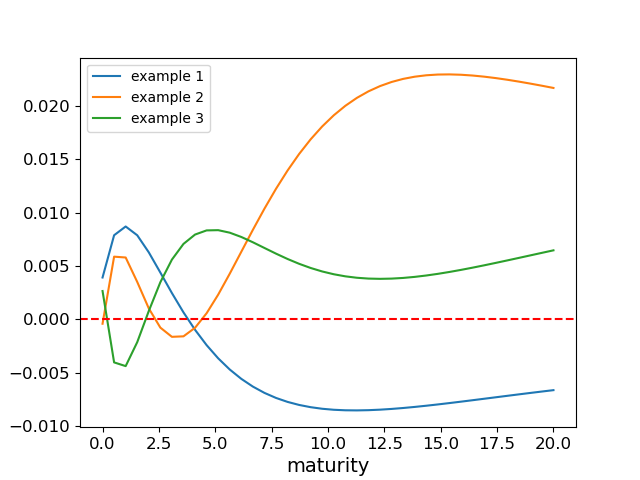

In [131]:
# every 3m up to 20y
ts = np.linspace(0, 20, 40).reshape(-1, 1)

plt.figure()
for i in range(num_examples):
    f = forward_curve(x[i])
    plt.plot(ts, f(ts), label='example %d' % (i+1))
plt.legend()
plt.axhline(linestyle='--', color='r')
plt.xlabel('maturity')
plt.ylabel('IFR')
plt.show()

Next, we examine the labels $y$. The yield curve in the first scenario, displayed in blue on the figure above, is labeled by the real number:

In [132]:
print(y[0])

[-1.64622873]


This is the continuation payoff in this scenario, simulated by Monte-Carlo. Assuming the early call is not exercised in two years, the holder remains in a thirteen-year payer swap, early callable once more, three years later. This second call will be exercised if and only if the present value of the swap with remaining maturity ten years, measured in three years time (five years from now), is negative. Otherwise, the floating and fixed leg of the swap will pay coupons for another ten years. The continuation payoff is therefore equal to: 

$$
y = swap\_pv\left(2y, 3y\right) + disc\left(2y, 3y\right) max\left(swap\_pv\left(5y, 10y\right), 0 \right)
$$

the present value, measured in 2y, of the swap coupons over the next 3y prior to the second call date, plus the value of the remaining 10y, measured on the second call date in 3y time (5y from now), if positive, discounted back to the first call date, two years from now. The continuation payoff depends on the state of the yield curve on the second call date (five years from now, three from the first call date), which is simulated with one Monte-Carlo path with initial state in 2y encoded in $X$. The label $y$ is equal to the continuation payoff, for a notional of 100. Crucially, the continuation <b> value </b> is the conditional expectation $E\left[y|X\right]$ and the holder will exercice the first call if and only if the continuation value is negative. Note that the continuation value is a function of $X$, measured in 2y on the first call date, whereas the payoff $y$ is measureable only on the second call date, three years later.

The differential labels $Z$ encode the <b> pathwise derivatives </b>, the gradient of the payoff $y$ wrt the initial state encoded in $X$. 

In [133]:
print(z[0])

[303.0416581  261.7829237  213.1187407  156.7832001   95.63003778]


The first number tells how much $y\left[0\right]$ reacts to an infinitesimal bump of $X\left[0,0\right]$, everything else (in particular, the random numbers in the simulation of the MC path) being unchanged.

The pathwise differentials were computed with Automatic Adjoint Differentiation or AAD, for a very small computation cost, and with analytic accuracy, see the [founding paper for AAD in finance](https://www.risk.net/derivatives/interest-rate-derivatives/1500261/smoking-adjoints-fast-monte-carlo-greeks), our [15-minutes presentation](https://towardsdatascience.com/automatic-differentiation-15min-video-tutorial-with-application-in-machine-learning-and-finance-333e18c0ecbb) or read the full story in the reference book [Modern Computational Finance](https://www.amazon.co.uk/Modern-Computational-Finance-Parallel-Simulations/dp/1119539455). IOt is those differential labels that enable powerful differential ML algorithms, as we are going to see.  

The test set consists of 128 independent examples where $X \in \mathbb{R}^5$ encodes the state of the curve in 2y like in the training data, and labels $y$ provide the ground truth continuation <b> value </b> in these states, computed by nested Monte-Carlo (although closed-form formulas are available in this simple example). Test differentials are not provided.

# Learning the continuation value by polynomial regression

Thankfully, dimension 5 is low enough so that the continuation value may be learned by regression, without the need for sophisticated ML models like neural networks. Note that the vast majority of problems in finance stand in (much) higher dimension, where regression is not applicable, so powerful dimension reduction techniques and/or sophisticated ML models are necessary.

Here, we perform classic polynomial regression of degree 5 over the training data, and measure the quality of the learned continuation value function by comparison with the correct values of the test set.

<IPython.core.display.Javascript object>


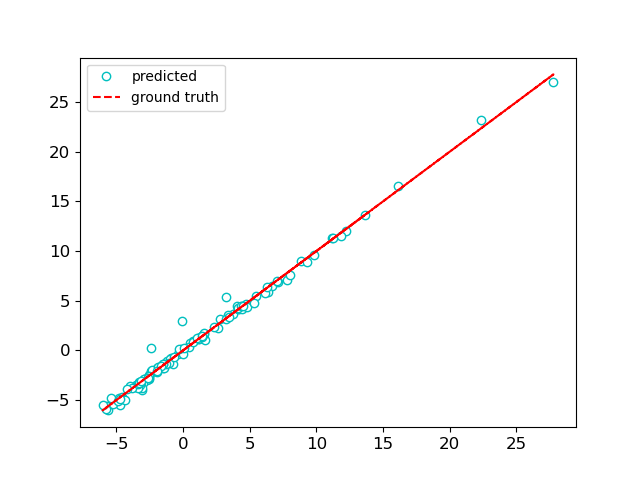

In [134]:
classic_reg = make_polynomial()
classic_reg.fit(x_train, y_train)
pred = classic_reg.predict(x_test)

plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

The performance of classic regression is decent, 32,768 training examples is not enough to learn a very accurate value function by classic regression. We can do a lot better with differential regression, leveraging the availability of differential training labels $Z$, as explained in [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb) (and even much better with the differential neural networks introduced in our October 2020 paper):

<IPython.core.display.Javascript object>


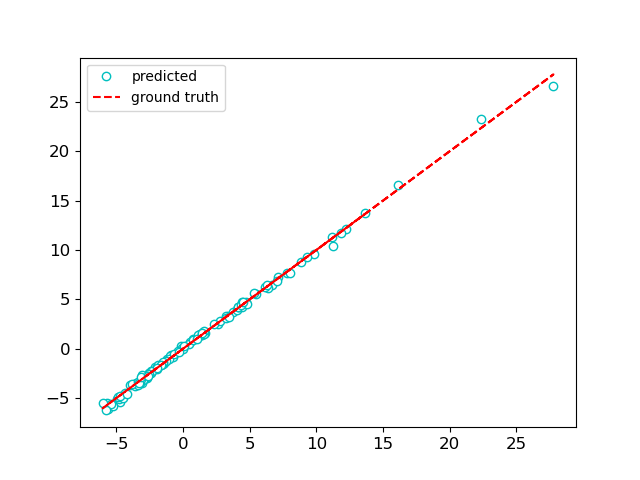

In [135]:
diff_reg = DifferentialRegression()
diff_reg.fit(x_train, y_train, z_train)
pred = diff_reg.predict(x_test)

plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

In the rest of the notebook, we focus on dimension reduction. Although a very decent continuation value function is learned by differential regression in this simple example, this cannot be generalized to more exotic Derivatives or trading books, where dimension routinely stands in the hundreds. Besides, we will see that, even in this simple context, continuation value is learned much faster and much more accurately in appropriately reduced dimension. Finally, dimension reduction provides invaluable insights into the factor-dependence and risk analysis of the Bermudan option, and all that follows carries over to arbitrary exotic Derivatives or trading books (modulo the necessity to switch to neural networks in situations where dimension cannot be sufficiently reduced for regression).

# Dimension reduction with classic PCA

Let us then reduce the dimension of the data, starting with classic PCA:

In [136]:
classic_pca = PCA()
classic_pca.fit(x_train)

PCA()

Here, we visualize the variance explained by the five components:

<IPython.core.display.Javascript object>


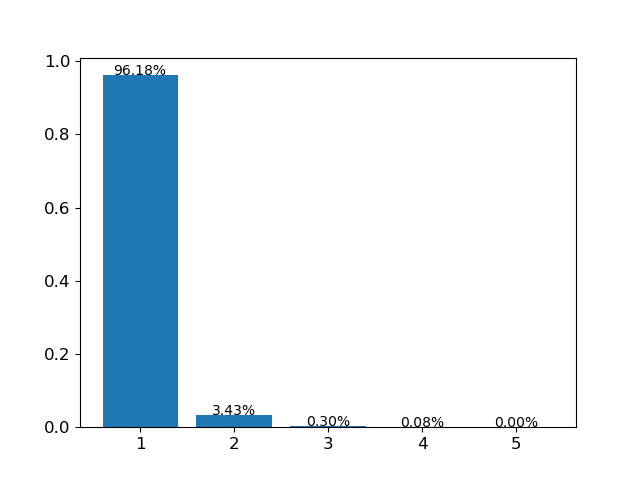

In [137]:
plt.figure()
plt.bar(range(1, classic_pca.n_components_ + 1), classic_pca.explained_variance_ratio_)
for index, value in enumerate(classic_pca.explained_variance_ratio_):
    plt.text(index+1, value, "{:.2%}".format(value), ha='center')

The two principal components explain 99.51% of the variance of the input data, and it certainly looks like the three remaining dimensions may be safely truncated. In particular, the 5th component explains less that half a basis point of the total variance. Let us then reduce dimension to two:

In [195]:
pca = PCA(2)
x_reduced = pca.fit_transform(x_train)
z_reduced = pca.transform(z_train) # z_reduced = d y / d x_reduced
print(x_reduced.shape, z_reduced.shape)

(32768, 2) (32768, 2)


And perform regression on the reduced data:

In [196]:
classic_reg.fit(x_reduced, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression(normalize=True))])

Now, we verify if dimension truncation deleted any meaningful information by attempting to learn continuation value from reduced data:

<IPython.core.display.Javascript object>


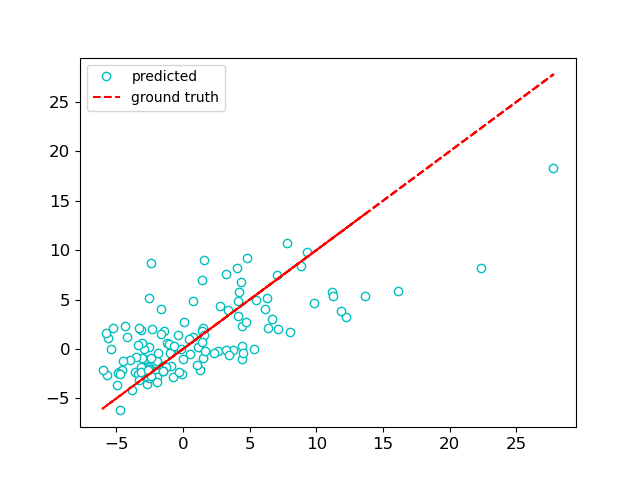

In [197]:
pred = classic_reg.predict(pca.transform(x_test))

plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

<b> No such luck! </b> the predicted values are terribly inaccurate. PCA truncated very meaningful information after all, despite insignificant variation. Of even more concern is that even differential regression cannot learn continuation values from the truncated data, and the problem persists in dimension 3 and even 4! It looks like any kind of dimension reduction by classic PCA, even by only one dimension, irreparably removes information significant for the Bermudan option. 

<IPython.core.display.Javascript object>


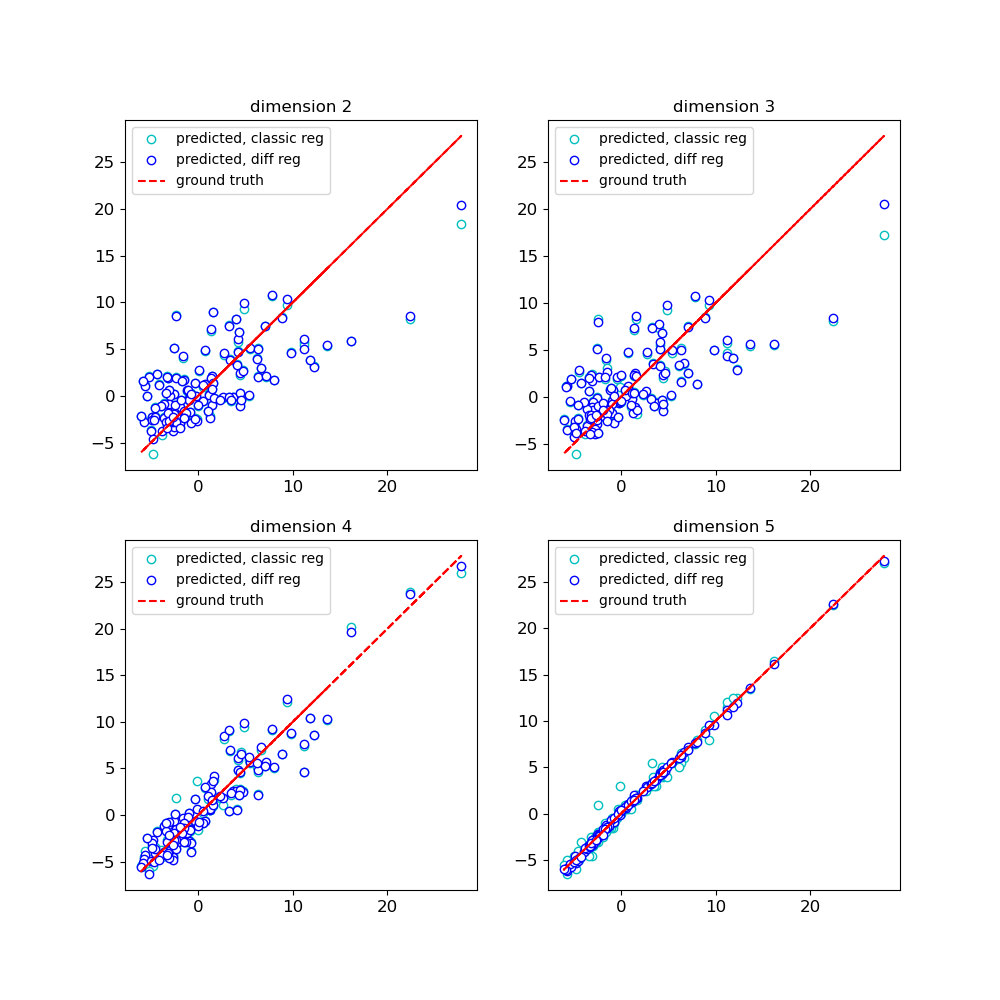

In [198]:
# perform classic PCA dimension reduction to 2, 3, 4 and 5 (5 means no reduction) 
# and verify the correctness of predicted continuation values against the ground thruth values of the test set 

classic_reg_pred = dict()
diff_reg_pred = dict()

# perform classic PCA in dimension 2 to 5, perform classic and differential regressions on the reduced data, 
# predict the test set and store results in classic_reg_pred and diff_reg_pred 
for dimension in range(2, 6):
    
    # classic PCA
    pca = PCA(dimension)
    
    # dimension reduction
    x_reduced = pca.fit_transform(x_train)
    # don't forget to modify differential data accordingly, for differential regression
    z_reduced = pca.transform(z_train)
    
    # classic regression on reduced data
    classic_reg.fit(x_reduced, y_train)
    classic_reg_pred[dimension] = classic_reg.predict(pca.transform(x_test))
    
    # differential regression on reduced data
    diff_reg.fit(x_reduced, y_train, z_reduced)
    diff_reg_pred[dimension] = diff_reg.predict(pca.transform(x_test))
    
# plot results

nplots = 4
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows, ncols, squeeze=False)
fig.set_size_inches(ncols * 5, nrows * 5)

for i, ax in enumerate(ax.flatten()):
    dimension = 2+i
    ax.plot(y_test, classic_reg_pred[dimension], 'co', markerfacecolor="white", label="predicted, classic reg")
    ax.plot(y_test, diff_reg_pred[dimension], 'bo', markerfacecolor="white", label="predicted, diff reg")
    ax.plot(y_test, y_test, 'r--', label="ground truth")
    ax.legend()
    ax.set_title("dimension %d" % dimension)


On a side note, the ML literature often recommends normalizing data $X$ (by subtracting means from columns and scaling by standard deviations). We try this below and demonstrate that normalization does not resolve the problem, or even improve things in a significant manner.

<IPython.core.display.Javascript object>


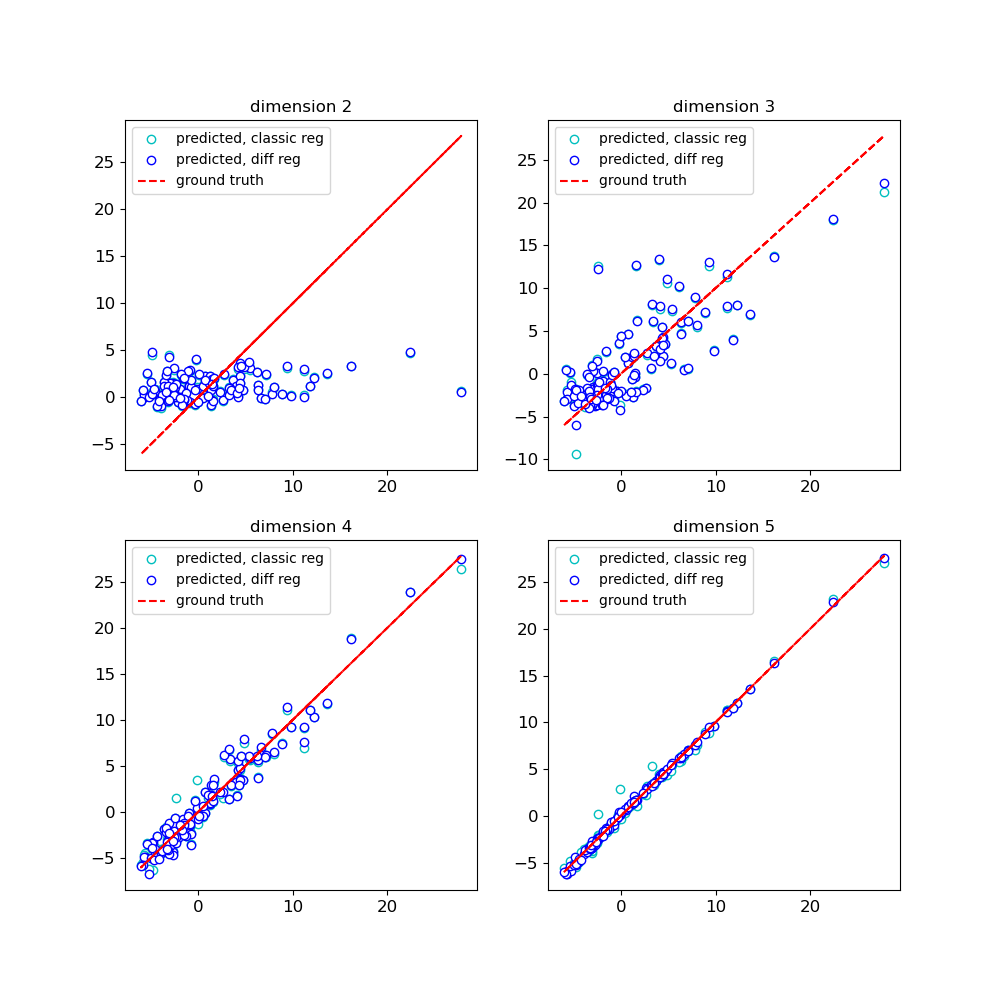

In [199]:
# normalize
mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_norm = (x_train - mean) / std
# don't forget to normalize differentials accordingly
z_norm = z_train * std

# normalize test set
x_test_norm = (x_test - mean) / std

# repeat
classic_reg_pred = dict()
diff_reg_pred = dict()

for dimension in range(2, 6):
    
    pca = PCA(dimension)
    
    x_reduced = pca.fit_transform(x_norm)
    z_reduced = pca.transform(z_norm)
    
    classic_reg.fit(x_reduced, y_train)
    classic_reg_pred[dimension] = classic_reg.predict(pca.transform(x_test_norm))
    
    diff_reg.fit(x_reduced, y_train, z_reduced)
    diff_reg_pred[dimension] = diff_reg.predict(pca.transform(x_test_norm))
    
# plot results

nplots = 4
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows, ncols, squeeze=False)
fig.set_size_inches(ncols * 5, nrows * 5)

for i, ax in enumerate(ax.flatten()):
    dimension = 2+i
    ax.plot(y_test, classic_reg_pred[dimension], 'co', markerfacecolor="white", label="predicted, classic reg")
    ax.plot(y_test, diff_reg_pred[dimension], 'bo', markerfacecolor="white", label="predicted, diff reg")
    ax.plot(y_test, y_test, 'r--', label="ground truth")
    ax.legend()
    ax.set_title("dimension %d" % dimension)


Normalization (slightly) improves things in dimension 3 and 4, although it makes them worse in dimension 2. 

It is important to understand why PCA manifestly cannot perform safe dimension reduction, despite only truncating coordinates of insignificant variation. Let us inspect the components of the PCA, scaled by root eigenvalue, so that the coordinates of $X$ in terms of the scaled components are independent, standard Gaussians. 

<IPython.core.display.Javascript object>


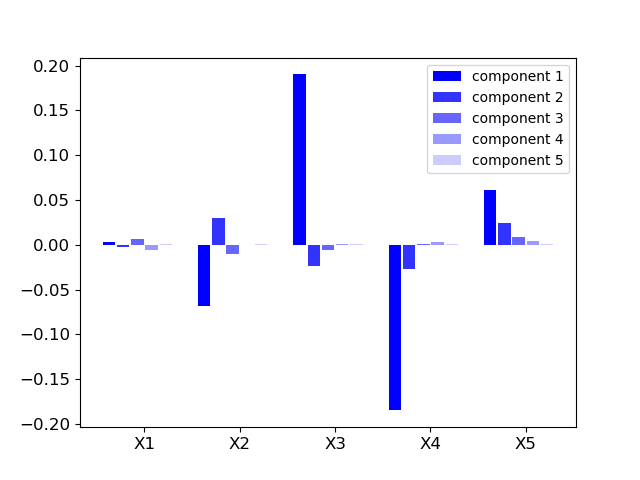

In [200]:
pca = PCA()
pca.fit(x_train)
scaled_components = pca.components_ * np.sqrt(pca.explained_variance_).reshape(-1, 1)

# plot the loadings of the scaled components in X1, X2, X3, X4 and X5
plt.figure()
xaxis = np.arange(1, 6)
for i, component in enumerate(scaled_components):
    plt.bar(xaxis+0.15*i, component, label='component %d' % (i+1), width=0.13, align='center', color='b', alpha=1-0.2*i)
plt.xticks(xaxis+0.375, ['X%d'%i for i in xaxis])
plt.legend()

This graph shows the $X_1, X_2, X_3, X_4$ and $X_5$ loadings of the five scaled components. From this point of view, the 4th and 5th components, at least, look definitely insignificant so we could  truncate them without causing harm. Yet, we know that this is not the case. Let us now examine those same scaled components, but in terms of forward rates rather than $X$s:

<IPython.core.display.Javascript object>


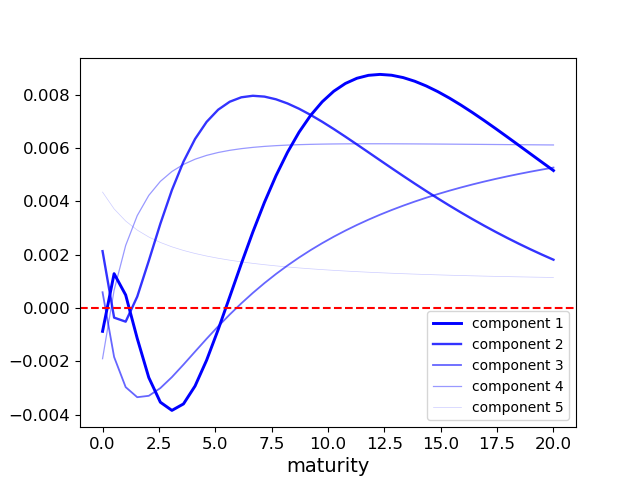

In [201]:
plt.figure()
for i, component in enumerate(scaled_components):
    f = forward_curve(component)
    # flip negative factors for a clearer picture
    fwds = f(ts)
    flip = -1 if fwds.mean() < 0 else 1 
    plt.plot(ts, flip*f(ts), label='component %d' % (i+1), color='b', alpha=1-0.2*i, linewidth = 2-0.4*i+0.1)
plt.legend()
plt.axhline(linestyle='--', color='r')
plt.xlabel('maturity')
plt.show()

This picture tells a very different story. All the components appear to encode significant variations of the yield curve. The 5th component, in particular, appears to be the main determinant of the short end of the curve. Recall that $f\left(T\right) - f\left(0, T\right) - g\left(T\right) = \sum_{i=1}^5 X_i e^{-\kappa_i T}$ so the short rate $f\left(0\right)$ (ignoring the deterministic part) is simply the sum of the $X$s. 

We draw below the sum of $X$ loadings of the scaled components, along with the sum of the squared loadings (which is simply the explained variance):

True


<IPython.core.display.Javascript object>


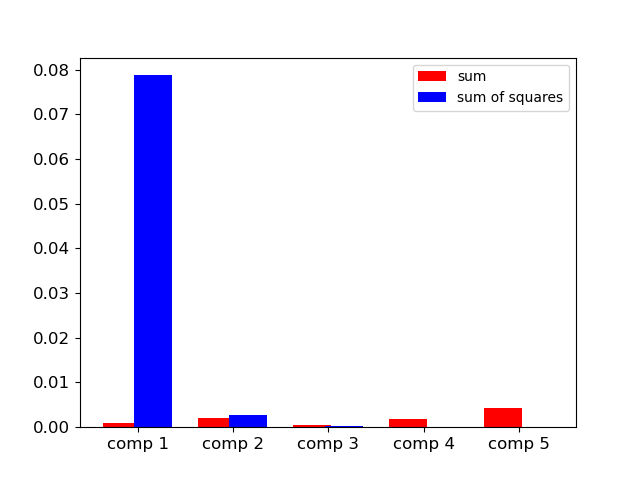

In [168]:
sums = scaled_components.sum(axis=1)
sumsq = (scaled_components**2).sum(axis=1)

# verify that sum of squares is explained variance
print(np.allclose(sumsq, pca.explained_variance_))

# plot
plt.figure()
xaxis = np.arange(1, 6)
plt.bar(xaxis+0.33, sums, label='sum', width=0.4, align='center', color='r')
plt.bar(xaxis+0.66, sumsq, label='sum of squares', width=0.4, align='center', color='b')
plt.xticks(xaxis+0.5, ['comp %d'%i for i in xaxis])
plt.legend()

Although the sum of squares (i.e. norm) of the 5th component is insignificant, its sum is the highest among all comopnents. The fith components therefore determines the state of the short end of the curve, despite its negligible variation. This is simply because in this example, the positive and negative loadings of the first (and second, third and forth) components compensate one another, whereas the positive loadings of the fith component add-up:

In [170]:
print (scaled_components[0], scaled_components[4])

[ 0.00281742 -0.06828391  0.19012787 -0.1848907   0.06110423] [0.00101714 0.0008961  0.0008742  0.00082509 0.00073097]


In [111]:
np.sum(scaled_components**2, axis=1), np.sum(scaled_components, axis=1)

(array([7.87375324e-02, 2.80907180e-03, 2.43464244e-04, 6.66473410e-05,
        3.81688455e-06]),
 array([0.00087491, 0.00213019, 0.00059024, 0.00190016, 0.0043435 ]))

We have now understood why PCA could not perform a safe dimension reduction. Insignificant variation in $X$ space translates into very significant variation in forward rate space, and rates are ultimately what matters for the Bermudan instrument. 

This example illustrates that PCA is unsafe and should never be applied pricing or risk context. Its performance heavily depends on the choice of representation. We encoded the state of the curve in terms of $X$s, but had we equivalently encoded it in terms of forward rates of different maturities spanning 0 to 20y, PCA could have correctly reduced dimension. PCA only works when the choice of representation is appropriate for a given problem. Because PCA is unsupervised, it doesn't know anything about the problem and it cannot make an informed representation choice. In other words, one must correctly guess the correct result beforehand in order to safely apply PCA.

# Dimension reduction with differential PCA

Differential PCA does not have this problem. Differential PCA truncates coordinates according to the magnitude of directional gradients, and gradients automatically scale with different representations. One doesn't have to guess the correct representation in order to apply differential PCA, the algorithm finds the correct representation from data, performing dimension reduction along the way by truncating axes of negligible gradient magnitude.

We very clearly illustrated that classic PCA is unsafe. By contrast, we formally demonstrated the safety of differential PCA in the Risk article. Here, we illustrate its safety and performance in the context of the Bermudan dataset.

We repeat the steps previously performed with classic PCA, this time with differential PCA. Fit on training data (including the critical differential data $Z$) and draw the bar chart of explained 'variance' (with differential PCA, this is actually the magnitude of the gradients):

<IPython.core.display.Javascript object>


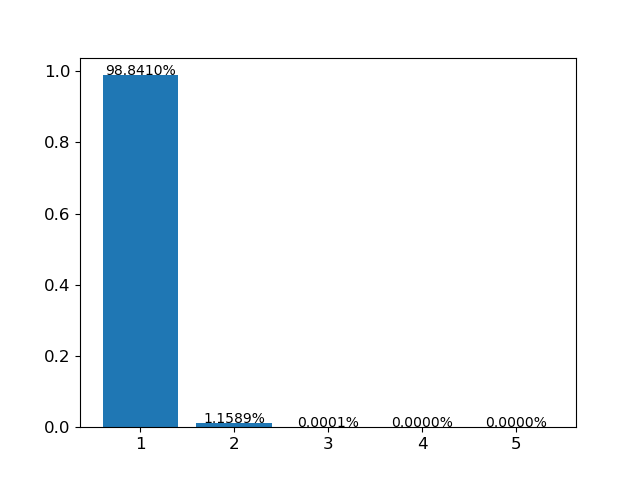

In [203]:
# fit
dpca = DiffPCA()
dpca.fit(x_train, z_train)

# plot
plt.figure()
plt.bar(range(1, dpca.n_components_ + 1), dpca.explained_variance_ratio_)
for index, value in enumerate(dpca.explained_variance_ratio_):
    plt.text(index+1, value, "{:.4%}".format(value), ha='center')

Differential PCA tells us that the two principal (differential) components account for 99.9999% of the total gradient magnitude, and that it is completely safe to reduce dimension to 2. Let us verify that with a copy of the code we used for classic PCA:

In [204]:
dpca = DiffPCA(2)
x_reduced, z_reduced = dpca.fit_transform(x_train, z_train)
print(x_reduced.shape, z_reduced.shape)

(32768, 2) (32768, 2)


And verify that we now learn correct continuation values from reduced data:

<IPython.core.display.Javascript object>


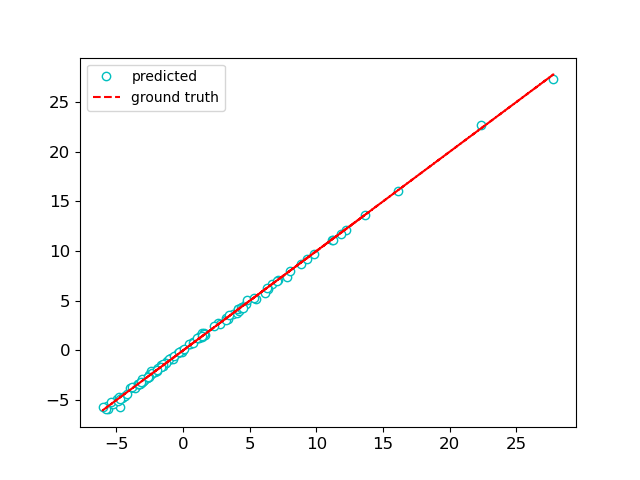

In [205]:
classic_reg.fit(x_reduced, y_train)
pred = classic_reg.predict(dpca.transform(x_test))

plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

Just works. Let us visualize the two risk factors, in forward rate space:

<IPython.core.display.Javascript object>


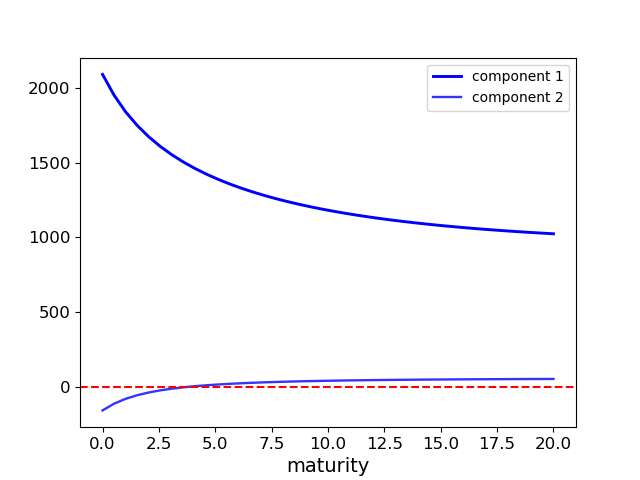

In [206]:
scaled_components = dpca.components_ * np.sqrt(dpca.explained_variance_).reshape(-1, 1)

plt.figure()
for i, component in enumerate(scaled_components):
    f = forward_curve(component)
    # flip negative factors for a clearer picture
    fwds = f(ts)
    flip = -1 if fwds.mean() < 0 else 1 
    plt.plot(ts, flip*f(ts), label='component %d' % (i+1), color='b', alpha=1-0.2*i, linewidth = 2-0.4*i+0.1)
plt.legend()
plt.axhline(linestyle='--', color='r')
plt.xlabel('maturity')
plt.show()

As expected, the main risk factor is shift of the curve, non-parallel and mainly affecting the short to medium end, and the second, much less prononced risk factor is a curve reversal around the second call date, distant by three years.

What about reducing dimension further to dimension 1, which account for 98.841% of the total risk magnitude, and given the small (but not negligible) magnitude of the second component in the forward rate representation?

(32768, 1) (32768, 1)


<IPython.core.display.Javascript object>


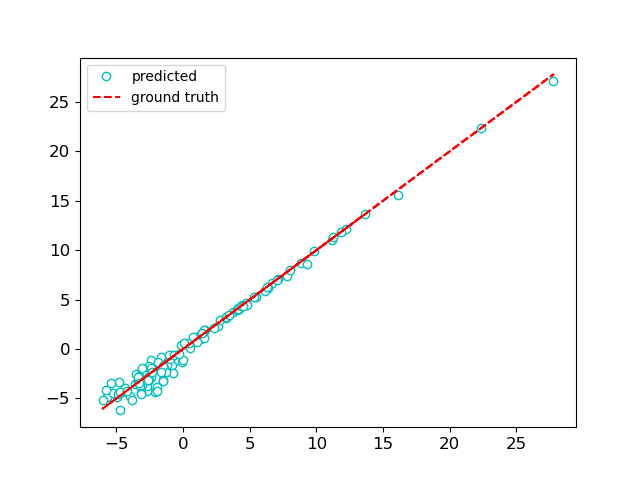

In [207]:
# reduce
dpca = DiffPCA(1)
x_reduced, z_reduced = dpca.fit_transform(x_train, z_train)
print(x_reduced.shape, z_reduced.shape)

# regress
classic_reg.fit(x_reduced, y_train)
pred = classic_reg.predict(dpca.transform(x_test))

# draw
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

Too far. Bermudan options are fundamentally two-factor instruments, as derived by Andersen and Andreasen by analysis. We just verified that from data. The factor dependence of any other Derivative instrument or trading book can be inferred from simulated data in an identical manner.

This conludes our exploration of the application of differential dimension reduction to real-world Derivatives problems. We clearly illustrated the danger of classic PCA for dimension reduction in the context of Derivatives pricing and risk, and the seamless performance of differential PCA, as demonstrated in the Risk article, along with its ability to correctly identify the factor depedency of Derivative instruments, reliably and automatically, from simulated data.